# Implementation of a KAN for regression
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of regression and compare it against a neural network of a similar architecture.

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


## Loading the Dataset

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
from analysis_functions import *
X_stress_components_new = opener("X_stress_components_new", path_import="./resourses/")
X_strain_components_new = opener("X_strain_components_new", path_import="./resourses/")
y_stress_components_new = opener("y_stress_components_new", path_import="./resourses/")
y_strain_components_new = opener("y_strain_components_new", path_import="./resourses/")
component_num = 1


cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X_stress_components_new[0], y_stress_components_new[0])
)


import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_x = [train_list_X[0], val_list_X[0]]  # a list of numpy arrays
my_x = train_list_X[0].T  # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)
my_y = [train_list_y[0], val_list_y[0]]  # another list of numpy arrays (targets)
my_y = train_list_y[0]  # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x)  # transform to torch tensor
tensor_y = torch.Tensor(my_y)

test_tensor_x = torch.Tensor(cur_X_test.T)
test_tensor_y = torch.Tensor(cur_y_test)

# my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
# my_dataloader = DataLoader(my_dataset) # create your dataloader

my_dataset = {
    "train_input": tensor_x,
    "test_input": test_tensor_x,
    "train_label": tensor_y,
    "test_label": test_tensor_y,
}


x_train = train_list_X[0]
x_val = val_list_X[0]

y_train = train_list_y[0].reshape(-1, 1)
y_val = val_list_y[0].reshape(-1, 1)

x_test = cur_X_test.T
y_test = cur_y_test.reshape(-1, 1)


train_dataset = {
    "train_input": torch.Tensor(x_train),
    "test_input": torch.Tensor(x_val),
    "train_label": torch.Tensor(y_train),
    "test_label": torch.Tensor(y_val),
}


./resourses//X_stress_components_new.pkl
./resourses//X_strain_components_new.pkl
./resourses//y_stress_components_new.pkl
./resourses//y_strain_components_new.pkl


In [10]:
print("Train data shape: {}".format(train_dataset['train_input'].shape))
print("Train target shape: {}".format(train_dataset['train_label'].shape))
print("Test data shape: {}".format(train_dataset['test_input'].shape))
print("Test target shape: {}".format(train_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([37480, 6])
Train target shape: torch.Size([37480, 1])
Test data shape: torch.Size([8040, 6])
Test target shape: torch.Size([8040, 1])


## Creating and Training the KAN

In [31]:
help(KAN)

Help on class MultKAN in module kan.MultKAN:

class MultKAN(torch.nn.modules.module.Module)
 |  MultKAN(width=None, grid=3, k=3, mult_arity=2, noise_scale=0.3, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun='silu', symbolic_enabled=True, affine_trainable=False, grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, seed=1, save_act=True, sparse_init=False, auto_save=True, first_init=True, ckpt_path='./model', state_id=0, round=0, device='cpu')
 |  
 |  KAN class
 |  
 |  Attributes:
 |  -----------
 |      grid : int
 |          the number of grid intervals
 |      k : int
 |          spline order
 |      act_fun : a list of KANLayers
 |      symbolic_fun: a list of Symbolic_KANLayer
 |      depth : int
 |          depth of KAN
 |      width : list
 |          number of neurons in each layer.
 |          Without multiplication nodes, [2,5,5,3] means 2D inputs, 3D outputs, with 2 layers of 5 hidden neurons.
 |          With multiplication nodes, [2,[5,3],[5,1],3] me

In [ ]:
image_folder = 'video_img'
from kan import KAN
model = KAN(width=[6, 3, 1], grid=10, k=3, seed=0, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [12]:
def train_mse():
    with torch.no_grad():
        predictions = model(train_dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, train_dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(train_dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, train_dataset['test_label'])
    return mse

results = model.fit(train_dataset, opt="LBFGS", metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=25, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

| train_loss: 4.82e+00 | test_loss: 5.06e+00 | reg: 1.89e+02 | : 100%|â–ˆ| 25/25 [01:53<00:00,  4.56s/

saving model version 0.1


In [13]:
print(results['train_mse'][-1], results['test_mse'][-1])

23.276132583618164 25.600257873535156


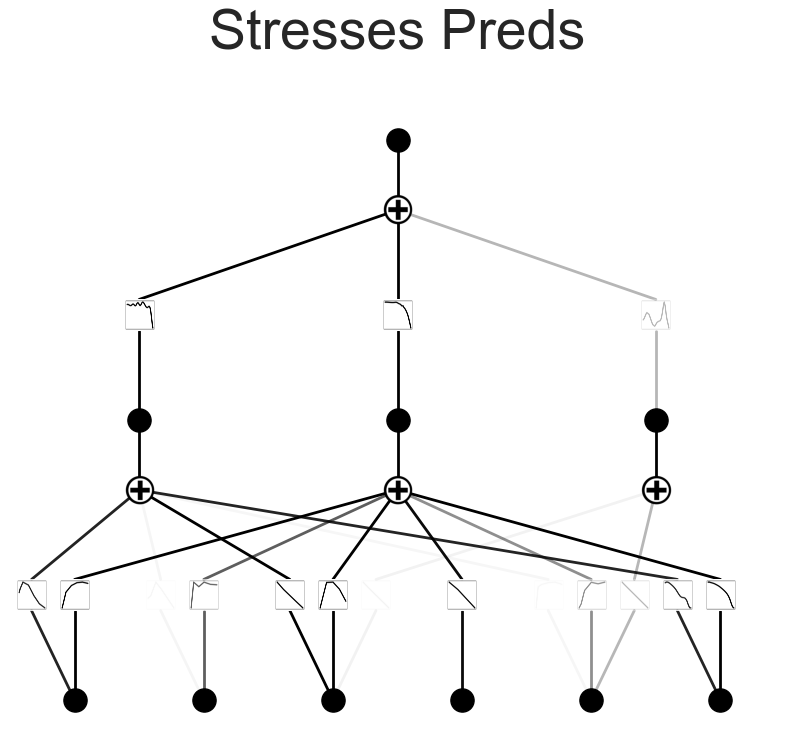

In [16]:
model.plot(beta=50, scale=1, out_vars=['Stresses Preds'])

In [20]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

MoviePy - Building video video.mp4.
MoviePy - Writing video video.mp4



MoviePy - Done !
MoviePy - video ready video.mp4


x_test_tensor shape: torch.Size([8040, 6])
y_pred shape: (8040, 1)
y_test shape: (8040, 1)


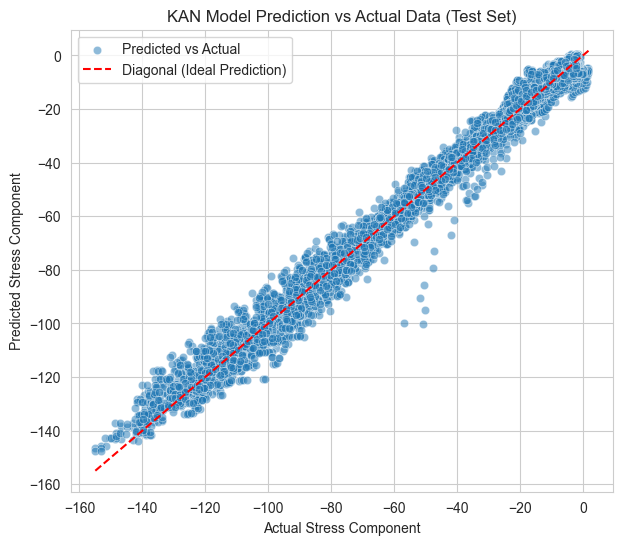

In [30]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure x_test is a PyTorch tensor
x_test_tensor = torch.Tensor(x_test).float().T
print("x_test_tensor shape:", x_test_tensor.shape)
# Make predictions using the model
with torch.no_grad():
    model.eval()
    y_pred_tensor = model(x_test_tensor)
    y_pred = y_pred_tensor.numpy()

print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)

# Plotting the results on the test set
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten(), alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("KAN Model Prediction vs Actual Data (Test Set)")
plt.legend()
plt.show()